CoNLL-2003 (https://www.clips.uantwerpen.be/conll2003/ner/) is a well-known data set for named entity recognition (NER) task, which provides the part-of-speech (POS) tag, chunking tag (for phrase) and name entity tag for every word in one line. The end of sentence corresponds to an empty line in the file.

In terms of the name entity tags, the data highlights those for **organization** (**I-ORG**), **person** (**I-PER**) and **location** (**I-LOC**), and marks the rest names as **miscellaneous** (**I-MISC**). Null label **O** is assigned to words that are not (part of) a name. 

Besides, there are certain situations that two phrases of the same type immediately follow each other, the first word of the second phrase is **B**-initialized instead to distinguish. For instance, "...Golan (I-LOC) Heights (I-LOC) Israel (**B-LOC**)...".

In [33]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, TimeDistributed, Dropout

pd.options.display.max_rows = 30

### Data preprocessing

#### Read in the training data, index the sentences, and remove the prefix (I and B) of entity tags.

In [2]:
train = pd.read_csv("./data/CoNLL-2003/eng.train", names=["word", "POS", "chunk", "origin_entity"], 
                    header=None, sep=" ", skip_blank_lines=False)

In [3]:
# drop prefix of name entity tag
train["entity"] = train["origin_entity"].str.rsplit("-", 1).str[-1]

In [4]:
# add sentence number
train["sentence"] = train.isnull().all(axis=1).cumsum()

In [5]:
# no longer needs the empty rows after indexing the sentences
train = train.dropna()

#### Encode the name entity tags and words.

In [6]:
entity_tag_encoder = LabelEncoder()
train['y'] = entity_tag_encoder.fit_transform(train.entity)

(array([  6.96900000e+03,   3.09300000e+03,   1.72900000e+03,
          1.47000000e+03,   1.16400000e+03,   4.29000000e+02,
          1.09000000e+02,   1.70000000e+01,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([   1.        ,    8.46666667,   15.93333333,   23.4       ,
          30.86666667,   38.33333333,   45.8       ,   53.26666667,
          60.73333333,   68.2       ,   75.66666667,   83.13333333,
          90.6       ,   98.06666667,  105.53333333,  113.        ]),
 <a list of 15 Patch objects>)

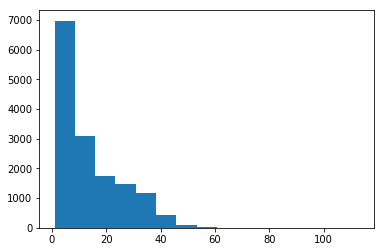

In [7]:
# take a look at the length distribution of sentences, most of which falls below 60
plt.hist(train.groupby('sentence').agg('count')['word'], bins=15)

In [8]:
word_encoder = LabelEncoder()
train['x'] = word_encoder.fit_transform(train.word)

In [9]:
x_train_sentence = train.groupby('sentence')['x'].apply(list)

In [10]:
word_encoder.inverse_transform(x_train_sentence[30])

array(['China', 'says', 'Taiwan', 'spoils', 'atmosphere', 'for', 'talks',
       '.'], dtype=object)

#### Pad sentences to the unifed length 60.

In [11]:
x_train_seq = pad_sequences(x_train_sentence, maxlen=60)

#### word embedding.

In [34]:
glove = pd.read_table('data/glove.6B.50d.txt', index_col=0, header=None, sep=' ', quoting=csv.QUOTE_NONE)

In [39]:
glove.index

Index([          u'the',             u',',             u'.',            u'of',
                  u'to',           u'and',            u'in',             u'a',
                   u'"',            u''s',
       ...
             u'sigarms',        u'katuna',           u'aqm',        u'1.3775',
       u'corythosaurus',        u'chanty',        u'kronik',       u'rolonda',
             u'zsombor',    u'sandberger'],
      dtype='object', name=0, length=400000)

### Model setting

In [23]:
NER = Sequential()
NER.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(60, 50)))
NER.add(TimeDistributed(Dense(5, activation='softmax')))
NER.add(Dropout(0.25))
NER.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
glove.loc["'s"]

1     0.237270
2     0.404780
3    -0.205470
4     0.588050
5     0.655330
6     0.328670
7    -0.819640
8    -0.232360
9     0.274280
10    0.242650
11    0.054992
12    0.162960
13   -1.255500
14   -0.086437
15    0.445360
        ...   
36   -0.339380
37   -0.199280
38    0.260490
39    0.104780
40   -0.559340
41   -0.123420
42    0.659610
43   -0.518020
44   -0.829950
45   -0.082739
46    0.281550
47   -0.423000
48   -0.273780
49   -0.007901
50   -0.030231
Name: 's, Length: 50, dtype: float64